In [450]:
#Data class
import random
class Sentiment: #enum class for describing the score

    NEGATIVE="NEGATIVE"
    NEUTRAL="NEUTRAL"
    POSITIVE="POSITIVE"
class Review:
    def __init__(self,text,score):
        self.text=text
        self.score=score
        self.sentiment=self.get_sentiment()

    def get_sentiment(self):
        if self.score<=2:
            return Sentiment.NEGATIVE
        elif self.score==3:
            return Sentiment.NEUTRAL
        else: #score of 4 or 5
            return Sentiment.POSITIVE
class ReviewContainer:
    def __init__(self,reviews):
        self.reviews=reviews
    
    def get_text(self):
        return [x.text for x in self.reviews]   #x is the input of the text to the training, doing list comprehension to get only the elements we need in a list.

    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]  #the input of the score to the training module.

    def evenly_distribute(self): #filters the reviews and creates a balance between number of positive and negative(same number)
        negative=list(filter(lambda x: x.sentiment==Sentiment.NEGATIVE,self.reviews))
        positive=list(filter(lambda x: x.sentiment==Sentiment.POSITIVE,self.reviews))
        positive_shrink=positive[:len(negative)]
        self.reviews=negative + positive_shrink
        random.shuffle(self.reviews)

In [451]:
#Load data
import json
file_name='./data/Books_small_10000.json'
reviews_list=[]
with open(file_name) as f: #with works like a scope where the code runs only there. (like inditation or brackets)
    for line in f:
        dict_data=json.loads(line) #loads text in json style into a json dic
        reviews_list.append(Review(dict_data['reviewText'],dict_data['overall'])) #create each element as Review class
        #append inserts data to a list, here we insert a tuple of two                 elements(the text and score).
reviews_list[1].sentiment


'NEUTRAL'

In [452]:
#Prep data
from sklearn.model_selection import train_test_split
training, test= train_test_split(reviews_list,test_size=0.31,random_state=42) #when we cross the 0.3 test size, our prediction accuracy gets worse, since it induces an overfitting for the model, too much data which is probably not that diverse.

#adding numerical values for the train set.
numerical_trainx=['10','6','5','4','2','10 out of 10','0']
numerical_trainy=[Sentiment.POSITIVE,Sentiment.NEUTRAL,Sentiment.NEUTRAL,Sentiment.NEGATIVE,Sentiment.NEGATIVE,Sentiment.POSITIVE,Sentiment.NEGATIVE]
train_container=ReviewContainer(training)
test_container=ReviewContainer(test)
train_container.evenly_distribute()
test_container.evenly_distribute()

train_x = train_container.get_text() 
train_y = train_container.get_sentiment()
#adding our custom set
train_x.extend(numerical_trainx)
train_y.extend(numerical_trainy)

test_x=test_container.get_text()
test_y=test_container.get_sentiment()
train_y.count(Sentiment.POSITIVE)
train_y.count(Sentiment.NEGATIVE)


456

In [453]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer()
train_x_vectors=vectorizer.fit_transform(train_x)
test_x_vectors=vectorizer.transform(test_x)
# print(test_y[3])
# print(train_x_vectors[0])

To declare a class and use it, the declation needs to be above the program ofc, otherwise we wont have the definition.(which is why Review class is above)
Basically, it makes the code more neat and clean using classes instead of indexes.

In [454]:
#Classification-> Linear SVM (support vector machine)
from sklearn import svm
clf_svm=svm.SVC(kernel='linear')
clf_svm.fit(train_x_vectors,train_y)
ypred=clf_svm.predict(test_x_vectors)


In [455]:
#Classification-> Decision Tree
from sklearn.tree import DecisionTreeClassifier

clf_dec=DecisionTreeClassifier()
clf_dec.fit(train_x_vectors,train_y)
clf_dec.predict(test_x_vectors[9])


array(['POSITIVE'], dtype='<U8')

In [456]:
#Classification-> Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf_gnb=GaussianNB()
clf_gnb.fit(train_x_vectors.toarray(),train_y)
clf_gnb.predict(test_x_vectors[3].toarray())

array(['NEGATIVE'], dtype='<U8')

In [457]:
#Evaluation
#Mean Accuracy
print(clf_svm.score(test_x_vectors,test_y))
print(clf_dec.score(test_x_vectors,test_y))
print(clf_gnb.score(test_x_vectors.toarray(),test_y))

0.8036649214659686
0.6387434554973822
0.6282722513089005


In [458]:
#F1 Scores
from sklearn.metrics import f1_score

f1_score(test_y,clf_svm.predict(test_x_vectors),average=None,labels=[Sentiment.POSITIVE,Sentiment.NEUTRAL,Sentiment.NEGATIVE])

#We got 91% for positive review, but bad 20% for neutral and negative.
#----
#after the twiching to data that we did, with evenly contributing and getting larger chunk of data, we got a 80% for positive and 80% for negative, quite nice in equality terms.

array([0.81, 0.  , 0.8 ])

In [459]:
#Testing the ML model with a custom set
test_set=['I thouroughly enjoyed this,5 stars'
,'bad book do not buy',
'horrible waste of time',
'The best thing ive ever seen.',
'10']
new_test=vectorizer.transform(test_set)
print(clf_svm.predict(new_test))

['POSITIVE' 'NEGATIVE' 'NEGATIVE' 'POSITIVE' 'POSITIVE']


<h4>Some extra analysis :</h4>

In [460]:
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(test_y, ypred))


precision    recall  f1-score   support

    NEGATIVE       0.81      0.79      0.80       191
    POSITIVE       0.80      0.82      0.81       191

    accuracy                           0.80       382
   macro avg       0.80      0.80      0.80       382
weighted avg       0.80      0.80      0.80       382



In [461]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[151  40]
 [ 35 156]]


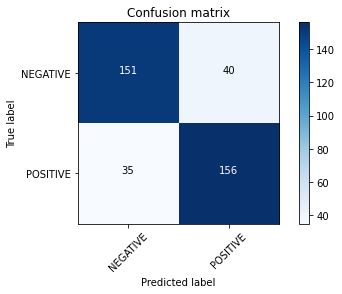

In [462]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, ypred, labels=[Sentiment.NEGATIVE,Sentiment.POSITIVE])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NEGATIVE','POSITIVE'],normalize= False,  title='Confusion matrix')
#as we can see, the prediction is pretty even on both sides.

#vectorizer.fit_transfrom explanation:

vectorizer.get_feature_names() == (
...     ['and', 'document', 'first', 'is', 'one',
...      'second', 'the', 'third', 'this'])
True

>>> X.toarray()
array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]]...)
       for every row in the matrix is a representation of the list we have
       above in get_feature_names(), and every digit in the corresponding
       place defines how many times that words show up in our corresponding
       row of matrix as the row of the string in our original tested list.
#another one:
.transform(X) = Transform dictionary features into 2D feature matrix.
.fit_transform(X) = learn feature names + .transform(X)
To answer your question:

You can .transform only after learning the features using .fit. Directly applying .transform will ignore any features not encoutered in .fit and hence, would not output any classification results.
